# Sphere and Torus Toy Datasets

> 2-Manifold with flow Datasets: The Sphere, The Torus, and the Paraboloid

In [ ]:
# default_exp datasets
# hide
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FlowNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

In building a battery of toy datasets for our directed graph embedding methods, the time has come to expand beyond the meager realm of 2-dimensional datasets, and into the vast (but still meager) world of 3d datasets.

This notebook builds pointclouds resembling a sphere, a torus, and a paraboloid, and assigns each a flow field.

In [ ]:
# hide
from FlowNet.datasets import plot_directed_3d, plot_3d

## Flows

Here's a bunch of sample flows in 3 space, which can be adapted to a variety of manifolds, like the sphere, torus, hyperboloid. The flows in this section don't have anything to do with the geometry of the manifold, but simply prescribe arrows to the entire 3 plane.

## Whirlpool

Our flow functions will involve radian-like coordinates, which use the angles of points relative to the origin

In [ ]:
# export
def angle_x(X):
    """Returns angle in [0, 2pi] corresponding to each point X"""
    X_complex = X[:,0] + np.array([1j])*X[:,1]
    return np.angle(X_complex)

In [ ]:
# export
def whirlpool(X):
    """Generates a whirlpool for flow assignment. Works in both 2d and 3d space.

    Parameters
    ----------
    X : ndarray
        input data, 2d or 3d
    """
    # convert X into angles theta, where 0,0 is 0, and 0,1 is pi/2
    X_angles = angle_x(X)
    # create flows
    flow_x = np.sin(2*np.pi - X_angles)
    flow_y = np.cos(2*np.pi - X_angles)
    output = np.column_stack([flow_x,flow_y])
    if X.shape[1] == 3:
        # data is 3d
        flow_z = np.zeros(X.shape[0])
        output = np.column_stack([output,flow_z])
    return output

## Torus

The torus must be sampled delicately. Here, we use a rejection sampling method, with code taken from Riddle's Diffusion Curvature project. (See x.riddle.press/diffusion_curvature)

In [ ]:
#export
def rejection_sample_for_torus(n, r, R):
    # Rejection sampling torus method [Sampling from a torus (Revolutions)](https://blog.revolutionanalytics.com/2014/02/sampling-from-a-torus.html)
    xvec = np.random.random(n) * 2 * np.pi
    yvec = np.random.random(n) * (1/np.pi)
    fx = (1 + (r/R)*np.cos(xvec)) / (2*np.pi)
    return xvec[yvec < fx]

def torus_with_flow(n=2000, c=2, a=1, flow_type = 'whirlpool', noise=None, seed=None, use_guide_points = False):
    """
    Sample `n` data points on a torus. Modified from [tadasets.shapes — TaDAsets 0.1.0 documentation](https://tadasets.scikit-tda.org/en/latest/_modules/tadasets/shapes.html#torus)
    Uses rejection sampling.

    In addition to the points, returns a "flow" vector at each point. 

    Parameters
    -----------
    n : int
        Number of data points in shape.
    c : float
        Distance from center to center of tube.
    a : float
        Radius of tube.
    flow_type, in ['whirlpool']

    ambient : int, default=None
        Embed the torus into a space with ambient dimension equal to `ambient`. The torus is randomly rotated in this high dimensional space.
    seed : int, default=None
        Seed for random state.
    """

    assert a <= c, "That's not a torus"

    np.random.seed(seed)
    theta = rejection_sample_for_torus(n-2, a, c)
    phi = np.random.random((len(theta))) * 2.0 * np.pi

    data = np.zeros((len(theta), 3))
    data[:, 0] = (c + a * np.cos(theta)) * np.cos(phi)
    data[:, 1] = (c + a * np.cos(theta)) * np.sin(phi)
    data[:, 2] = a * np.sin(theta)

    if use_guide_points:
        data = np.vstack([[[0,-c-a,0],[0,c-a,0],[0,c,a]],data])

    if noise:
        data += noise * np.random.randn(*data.shape)
    
    if flow_type == 'whirlpool':
        flows = whirlpool(data)
    else:
        raise NotImplementedError
    # compute curvature of sampled torus
    ks = 8*np.cos(theta)/(5 + np.cos(theta))

    return data, flows

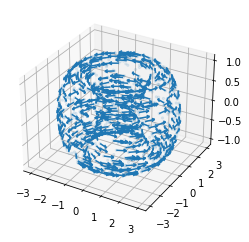

In [ ]:
# collapse
X, flows = torus_with_flow(n=2000)
plot_directed_3d(X,flows)

## Hypersphere

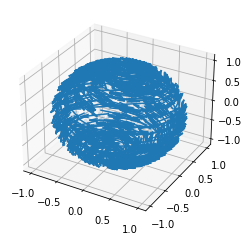

In [ ]:
# collapse
import tadasets
X = tadasets.sphere(n=2000,r=1)
flows = whirlpool(X)
plot_directed_3d(X,flows,mask_prob=0.6)